In [77]:
from math import radians, cos, sin, asin, sqrt 
def calculate_distance(lon1, lat1, lon2, lat2): 
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) 
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371 
    km = 6371* c 
    return km

In [78]:
def next_cluster(lng,lat,cluster_df):
    smallest_value = 9999999999999999 #nicht schön aber sollte funktionieren.
    for index, row in cluster_df.iterrows():
        cluster_lng = row["lng"]
        cluster_lat = row["lat"]
        distance = calculate_distance(lng,lat,cluster_lng,cluster_lat)
        if distance < smallest_value:
            smallest_value = distance
            closest_cluster = [cluster_lng,cluster_lat]
    return closest_cluster

# Task 1

## Import Libraries

In [79]:
#Data
import pandas as pd
import numpy as np

#Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#Geo-Visualisation
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz

## Import raw data and merge the data
We merge the raw data in order to apply cleaning and calculated metrics to the raw data for both cities at once.
We will split it back up later for analysis.

In [80]:
df_b= pd.read_csv("./dataset/bochum.csv")
df_l = pd.read_csv("./dataset/leipzig.csv")

In [81]:
#Self-gathered datasets that gives information about the relevant days
date_info_l = pd.read_csv("./resources/date-info/leipzig-dateinfo.csv",sep=";")
date_info_l["date"] = pd.to_datetime(date_info_l["date"],format="%d.%m.%Y").dt.date
date_info_l.index = date_info_l["date"]
date_info_l = date_info_l.drop(columns=["date"])

date_info_b = pd.read_csv("./resources/date-info/leipzig-dateinfo.csv",sep=";")
date_info_b["date"] = pd.to_datetime(date_info_b["date"],format="%d.%m.%Y").dt.date
date_info_b.index = date_info_b["date"]
date_info_b = date_info_b.drop(columns=["date"])

In [82]:
leipzig = {"lng": 12.3741468,"lat": 51.340744}
bochum = {"lng": 7.2164417,"lat": 51.4816637}

In [83]:
leipzig_map = gpd.read_file("./resources/leipzig/ot.shp").to_crs(epsg=4326) #original file is in a different system
bochum_map = gpd.read_file("./resources/bochum/Stadtbezirke.shp").to_crs(epsg=4326).rename(columns={"Stadtbezir":"Name"})

## Look for null values

In [84]:
print("Total number of null values:",
      (sum(df_l.isnull().sum())+sum(df_l.isnull().sum())))

Total number of null values: 0


## Correct Data Types

In [85]:
def correct_data_types(Nextbike):
    #Converting Trip Length to timedelta
    Nextbike['trip_duration'] = pd.to_timedelta(Nextbike['trip_duration'])

    #Converting start-time to datetime
    Nextbike['timestamp'] = pd.to_datetime(Nextbike['day'] + ' ' +  Nextbike['time'])
    Nextbike.drop(columns=['day','time'], inplace = True)

    #round coordinates to filter out gps unpreciseness
    cols = ["orig_lat","orig_lng","dest_lat","dest_lng"]
    Nextbike[cols] = Nextbike[cols].round(3)
    
    return Nextbike

df_l = correct_data_types(df_l)
df_b = correct_data_types(df_b)

## Add columns for analysis

In [86]:
def add_columns_analysis(Nextbike,date_info):
    Nextbike['timestamp_rounded'] = Nextbike['timestamp'].dt.floor('H')


    Nextbike["date"] = Nextbike.timestamp.dt.date
    Nextbike['weekday'] = Nextbike['timestamp_rounded'].dt.weekday
    Nextbike['week'] = Nextbike['timestamp_rounded'].dt.isocalendar().week

    Nextbike['Time'] = Nextbike['timestamp_rounded'].dt.time
    Nextbike["Time"] = Nextbike["Time"].astype(str).str[:2].astype(int)

    Nextbike['Time_float'] = Nextbike['timestamp'].dt.time
    Nextbike['Time_float'] = Nextbike['Time_float'].astype(str).str[3:5].astype(float)/60 + Nextbike["Time"]
    #take trip duration in minutes, calculate 1€ per 30 minutes of usage
    Nextbike["revenue"] = np.ceil((Nextbike.trip_duration.dt.total_seconds()/60) /30)
      
        
    Nextbike=pd.merge(Nextbike,date_info,left_on="date",right_index=True)
    Nextbike["free"] = ((Nextbike["day_classifier"]=="weekend") | (Nextbike["holiday"]=="1"))
    
    return Nextbike


df_l = add_columns_analysis(df_l,date_info_l)
df_b = add_columns_analysis(df_b,date_info_b)

df_l

b_number     city   trip_duration  orig_lat  orig_lng  dest_lat  \
0          10900  leipzig 0 days 00:12:00    51.330    12.342    51.330   
1          10900  leipzig 0 days 00:08:00    51.330    12.342    51.330   
2          10900  leipzig 0 days 00:40:00    51.330    12.342    51.330   
3          10900  leipzig 0 days 00:03:00    51.330    12.342    51.330   
2788       20204  leipzig 0 days 00:13:00    51.333    12.404    51.339   
...          ...      ...             ...       ...       ...       ...   
171614     39065  leipzig 0 days 00:38:00    51.326    12.375    51.331   
171615     39065  leipzig 0 days 00:10:00    51.331    12.374    51.335   
171616     39065  leipzig 0 days 00:07:00    51.335    12.391    51.332   
171617     39065  leipzig 0 days 00:09:00    51.331    12.406    51.319   
171618     39065  leipzig 0 days 00:10:00    51.319    12.401    51.333   

        dest_lng           timestamp   timestamp_rounded        date  weekday  \
0         12.342 2019-04-16 11:17:00 2019-04-16 11:00:00  2019-04-16        1   
1         12.342 2019-04-16 11:35:00 2019-04-16 11:00:00  2019-04-16        1   
2         12.342 2019-04-16 11:53:00 2019-04-16 11:00:00  2019-04-16        1   
3         12.342 2019-04-16 14:35:00 2019-04-16 14:00:00  2019-04-16        1   
2788      12.382 2019-04-16 05:52:00 2019-04-16 05:00:00  2019-04-16        1   
...          ...                 ...                 ...         ...      ...   
171614    12.374 2019-03-27 15:06:00 2019-03-27 15:00:00  2019-03-27        2   
171615    12.391 2019-03-27 16:28:00 2019-03-27 16:00:00  2019-03-27        2   
171616    12.406 2019-03-27 17:09:00 2019-03-27 17:00:00  2019-03-27        2   
171617    12.401 2019-03-27 18:00:00 2019-03-27 18:00:00  2019-03-27        2   
171618    12.412 2019-03-27 20:59:00 2019-03-27 20:00:00  2019-03-27        2   

        week  Time  Time_float  revenue day_classifier  vacations  holiday  \
0         16    11   11.283333      1.0        weekday          0        0   
1         16    11   11.583333      1.0        weekday          0        0   
2         16    11   11.883333      2.0        weekday          0        0   
3         16    14   14.583333      1.0        weekday          0        0   
2788      16     5    5.866667      1.0        weekday          0        0   
...      ...   ...         ...      ...            ...        ...      ...   
171614    13    15   15.100000      2.0        weekday          0        0   
171615    13    16   16.466667      1.0        weekday          0        0   
171616    13    17   17.150000      1.0        weekday          0        0   
171617    13    18   18.000000      1.0        weekday          0        0   
171618    13    20   20.983333      1.0        weekday          0        0   

         free  
0       False  
1       False  
2       False  
3       False  
2788    False  
...       ...  
171614  False  
171615  False  
171616  False  
171617  False  
171618  False  

[185327 rows x 19 columns]

In [87]:
#Creates a df with all dates from df
start_date = df_l.date.min()
end_date = df_l.date.max()
delta = pd.to_timedelta("1d")
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta

## Cleaning up unrealistic rides
This step is aimed at filtering out rides that have start or end locations far out from the city and thus is likely not a regular ride within the valid area. We 

Text(0.5, 1.0, 'Bochum')

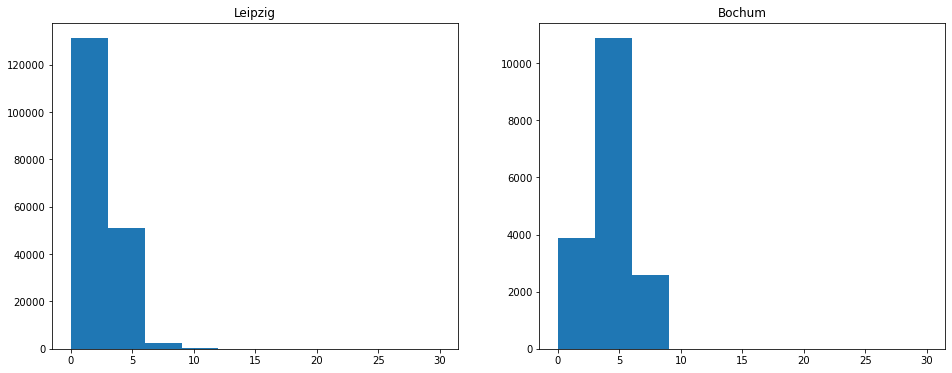

In [88]:
def add_distances_center(df,city):
    start_distance_center = []
    end_distance_center = []
    max_distance_center = []

    for index, row in df.iterrows():
        start = calculate_distance(lon1 = row["orig_lng"],
                               lat1 = row["orig_lat"],
                               lon2 = city["lng"],
                               lat2 = city["lat"])
        end = calculate_distance(lon1 = row["dest_lng"], 
                                lat1 = row["dest_lat"],
                                lon2 = city["lng"],
                                lat2 = city["lat"])
        if start > end:
            max = start
        else:
            max = end
        start_distance_center.append(start)
        end_distance_center.append(end)
        max_distance_center.append(max)

    df["start_distance_center"] = start_distance_center
    df["end_distance_center"] = end_distance_center
    df["max_distance_center"] = max_distance_center

    #df["max_distance_center"] = df["max_distance_center"].round()

    distances = df.groupby("max_distance_center").agg(
    count = ("b_number","count"))

    
add_distances_center(df_l,leipzig)
add_distances_center(df_b,bochum)

# Output
Fig_1, axes = plt.subplots(1, 2, figsize=(16, 6))

x = df_l["max_distance_center"]
axes[0].hist(x,range=(0,30))
axes[0].set_title('Leipzig')

x = df_b["max_distance_center"]
axes[1].hist(x,range=(0,30))
axes[1].set_title('Bochum')

In [89]:
df_l = df_l[df_l["max_distance_center"]<=15]
df_b = df_b[df_b["max_distance_center"]<=10]

## Find out size of the fleet
The idea is that a bike is recognized as part of the fleet if it has been rented in the last 7 days. So the size of the fleet is the amount of unique Bike IDs that have records for the last 7 days. We calculate this on a daily level to be precise yet not too intense to compute.

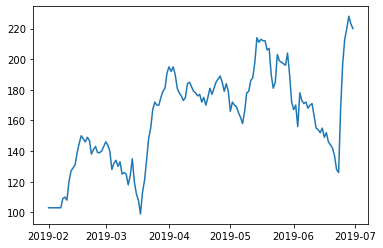

In [149]:
plt.plot(fleet_size_b)

In [90]:
def fleet_size(df,factor):
    
    fleet_size = pd.DataFrame([], index = dates, columns = ["fleet_size"]) 

    search_array = []
    values = []
    for index, row in fleet_size.iterrows():
        search_array.append(index)
        if len(search_array) > factor:
            search_array.pop(0)
        values.append(df[df["date"].isin(search_array[:])].b_number.nunique())
        
    i = 0
    
    #Erklärung hierfür
    correction = values[factor-1]
    while i < factor-1:
        values[i] = correction
        i = i + 1
    fleet_size["fleet_size"] = values
    
    return fleet_size

fleet_size_l = fleet_size(df_l,7)
fleet_size_b = fleet_size(df_b,7)

## Creating per-day DataFrame

In [100]:
def df_by_date(df,fleet_size):
    df_by_date = df.groupby("date").agg(
        revenue=('revenue', "sum"),
        trips=("b_number","count"),
        free = ("free","min"),
        used_bikes=('b_number', pd.Series.nunique))

    df_by_date_merged = df_by_date.join(fleet_size) #this does not include the missing days
    df_by_date_merged["daily_usage"] = df_by_date_merged["used_bikes"] / df_by_date_merged["fleet_size"]
    df_by_date_merged = df_by_date_merged.rename(columns={"trips": "daily_trips","revenue":"daily_revenue", "used_bikes":"daily_used_bikes"})
    
    return df_by_date_merged


df_date_l = df_by_date(df_l,fleet_size_l)
df_date_b = df_by_date(df_b,fleet_size_b)

df_date_b

daily_revenue  daily_trips   free  daily_used_bikes  fleet_size  \
date                                                                          
2019-02-01           49.0           40  False                29         103   
2019-02-02           30.0           27   True                19         103   
2019-02-03           36.0           27   True                20         103   
2019-02-04           67.0           47  False                33         103   
2019-02-05           97.0           79  False                51         103   
...                   ...          ...    ...               ...         ...   
2019-06-26          371.0          255  False               115         213   
2019-06-27          348.0          242  False               107         220   
2019-06-28          375.0          255  False               128         228   
2019-06-29          164.0          124   True                73         223   
2019-06-30          143.0           92   True                56         220   

            daily_usage  
date                     
2019-02-01     0.281553  
2019-02-02     0.184466  
2019-02-03     0.194175  
2019-02-04     0.320388  
2019-02-05     0.495146  
...                 ...  
2019-06-26     0.539906  
2019-06-27     0.486364  
2019-06-28     0.561404  
2019-06-29     0.327354  
2019-06-30     0.254545  

[147 rows x 6 columns]

## Creating per-hour DataFrame
This DataFrame is the core of the project as most of the analyses rely on hourly data. It contains all useful hour-level data, and it contains all day-level data such as fleet size, day classifiers etc.

In [92]:
def df_by_hour(df,df_date):

    df_by_hour = df.groupby("timestamp_rounded").agg(
        revenue=('revenue', "sum"),
        trips=("b_number","count"),
        date=("date","min"),
        time = ("Time","min"),
        weekday=("weekday","min"),
        week = ("week","min"),
        used_bikes=('b_number', pd.Series.nunique))


    df_by_hour_merged = pd.merge(df_by_hour, df_date, right_index=True, left_on='date')


    df_by_hour_merged["usage"] = df_by_hour_merged["used_bikes"] / df_by_hour_merged["fleet_size"]
    df_by_hour_merged["relative_trips"] = df_by_hour_merged["trips"] / df_by_hour_merged["daily_trips"]
    
    return df_by_hour_merged


df_hour_l = df_by_hour(df_l, df_date_l)
df_hour_b = df_by_hour(df_b, df_date_b)

# Rental Patterns

### Hourly Trip distribution

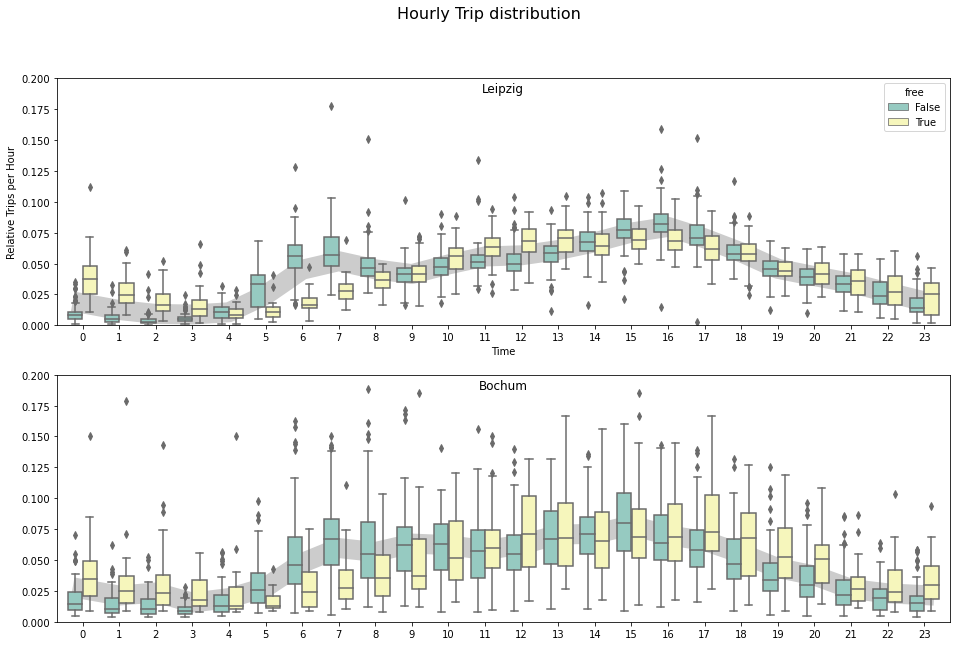

In [93]:
daily_trend_l = df_hour_l[["time","free","relative_trips"]]
daily_trend_b = df_hour_b[["time","free","relative_trips"]]

# Create a figure (empty work space)
Fig_1,axes = plt.subplots(2, 1, figsize=(16, 10))
Fig_1.suptitle('Hourly Trip distribution', fontsize=16)

i = 0
daily_trends = [daily_trend_l,daily_trend_b]
for daily_trend in daily_trends:
    boxplot = sns.boxplot(ax = axes[i],
                     data=daily_trend, 
                     x="time", 
                     y="relative_trips", 
                     hue='free', 
                     palette="Set3",
                     zorder = 1)
    
    daily_trend_avg = daily_trend.groupby("time").agg(relative_trips = ("relative_trips","mean"))
    avg = axes[i].plot(daily_trend_avg.index,
                       daily_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 0.2))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Relative Trips per Hour')
axes[0].set_xlabel('Time')
axes[1].legend().remove()

## Geographic Rental Patterns

In [57]:
def area_array(df,polys,lng,lat):
    
    gdf = gpd.GeoDataFrame(df[[lng,lat]], geometry=gpd.points_from_xy(df[lng], df[lat]))
    
    stadtteile = []

    for index,row in gdf.iterrows():
        point = row["geometry"]
        stadtteil = None
        
        for indox,rew in polys.iterrows():
            if point.within(rew["geometry"]):
                stadtteil = rew["Name"]
                break
                
        stadtteile.append(stadtteil)
       
    return stadtteile

In [75]:
df_l["start_area"] = area_array(df_l,leipzig_map,"orig_lng","orig_lat")
df_l["end_area"] = area_array(df_l,leipzig_map,"dest_lng","dest_lat")
df_b["start_area"] = area_array(df_b,bochum_map,"orig_lng","orig_lat")
df_b["end_area"] = area_array(df_b,bochum_map,"dest_lng","dest_lat")

In [63]:
def plot_quarter_days(df,polys,slices):
    slice_size = 24/slices
    fig, axes = plt.subplots(2, slices, figsize=(30,20))
    fig.suptitle('Start and End Areas on Working days, Leipzig', fontsize=24)
    i=0
    while i < slices:
        min_time = slice_size*i
        max_time = min_time + slice_size - 1
        dfx = df[(df["Time"]>=min_time)&(df["Time"]<=max_time)]  # filter out only weekdays

        plottable_start = dfx.groupby("start_area").agg(count = ("start_area","count"))
        plottable_start = pd.merge(polys, plottable_start, left_on="Name", right_index=True)
        
        plottable_end = dfx.groupby("end_area").agg(count = ("end_area","count"))
        plottable_end = pd.merge(polys, plottable_end, left_on="Name", right_index=True)
            
        plottable_start.plot(ax=axes[0,i], alpha=0.8, edgecolor='darkgrey',cmap="Blues",column='count', zorder=1,  legend=False)
        ctx.add_basemap(ax=axes[0,i],crs=4326)
        polys.plot(ax=axes[0,i],zorder=3,alpha=0)
        axes[0,i].set_title('Start, '+str(min_time)+"h to " + str(max_time) + "h")
        
        plottable_end.plot(ax=axes[1,i], alpha=0.8, edgecolor='darkgrey',cmap="Blues",column='count', zorder=1,  legend=False)
        ctx.add_basemap(ax=axes[1,i],crs=4326)
        polys.plot(ax=axes[1,i],zorder=3,alpha=0)
        axes[1,i].set_title('End, '+str(min_time)+"h to " + str(max_time) + "h")
        i = i + 1
    
    ylim1,ylim2 = axes[0,0].get_ylim()
    xlim1,xlim2 = axes[0,0].get_xlim()

    for axis in axes[0]:
        axis.set_ylim(ylim1,ylim2)
        axis.set_xlim(xlim1,xlim2)
    for axis in axes[1]:
        axis.set_ylim(ylim1,ylim2)
        axis.set_xlim(xlim1,xlim2)

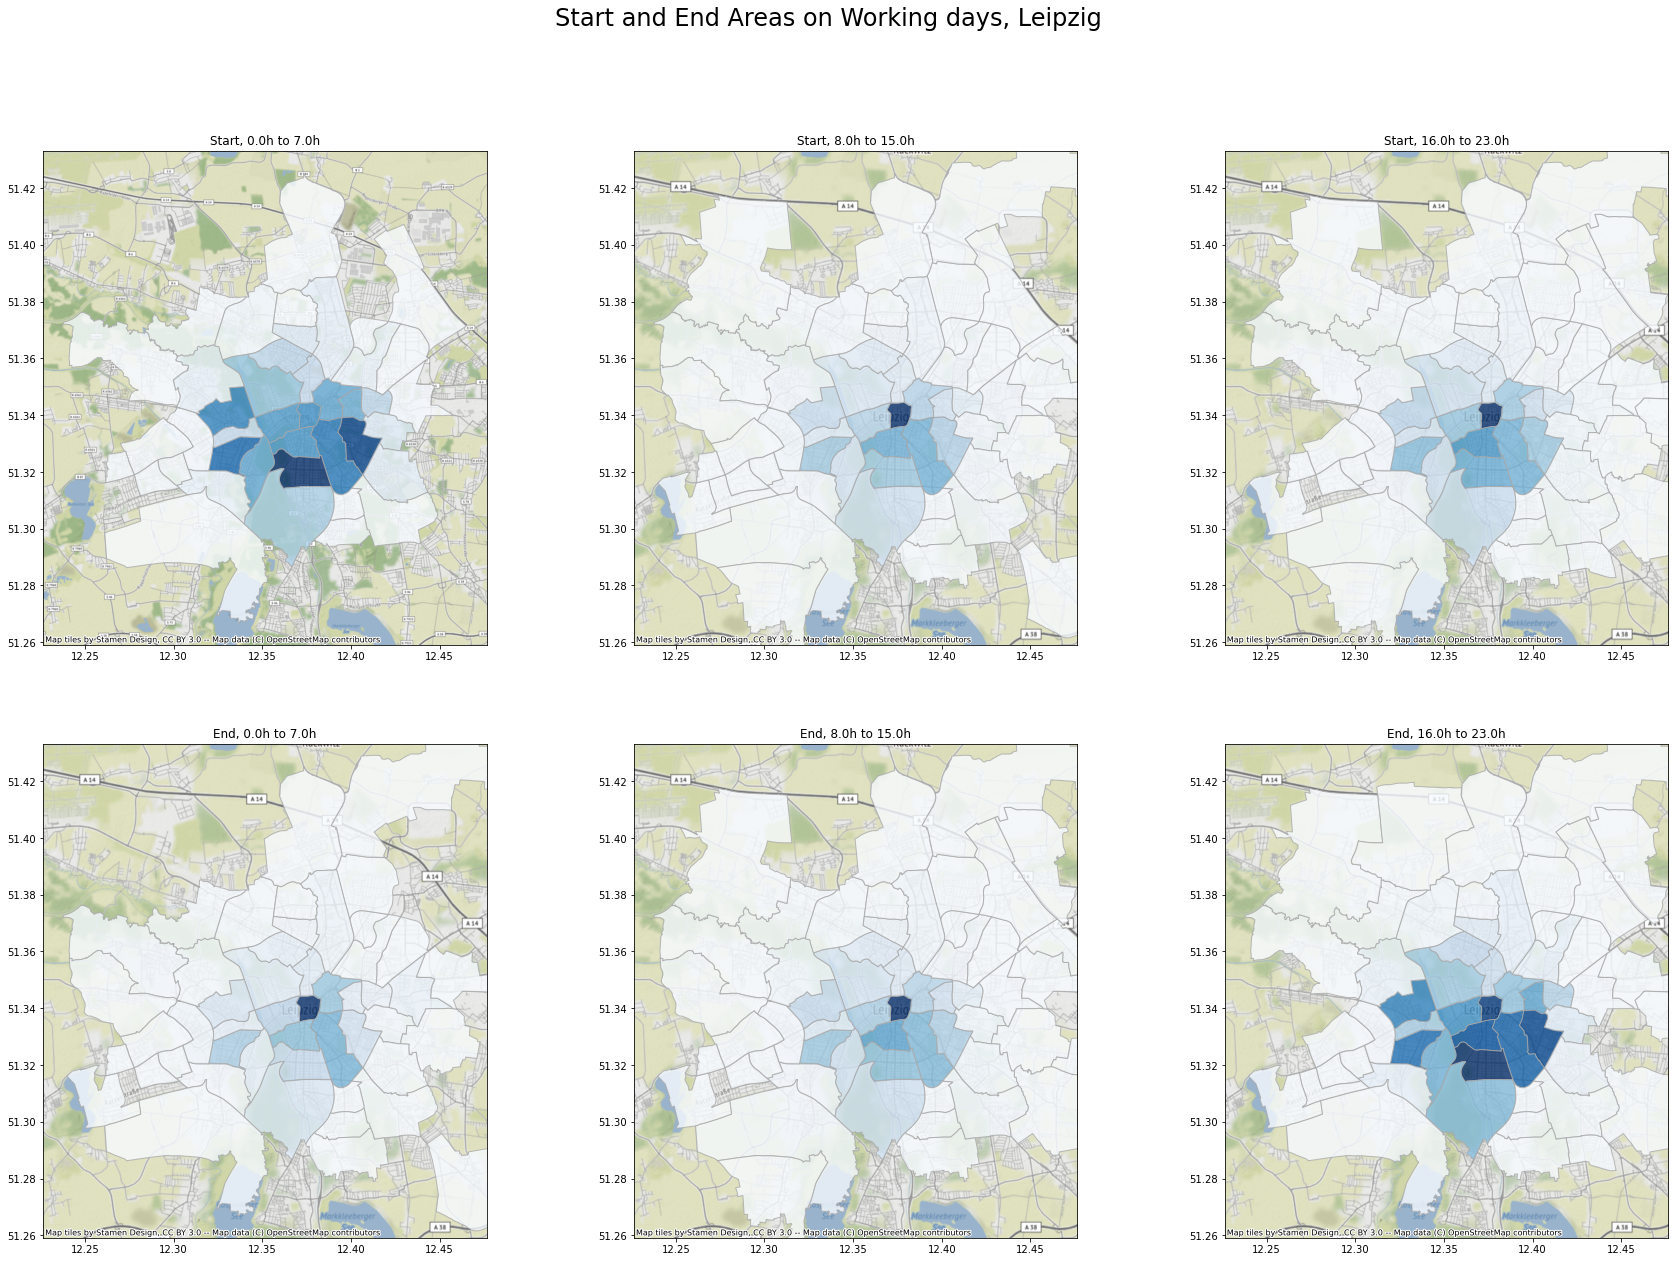

In [64]:
plot_quarter_days(df=df_l[df_l["free"]==False],polys=leipzig_map,slices=3)

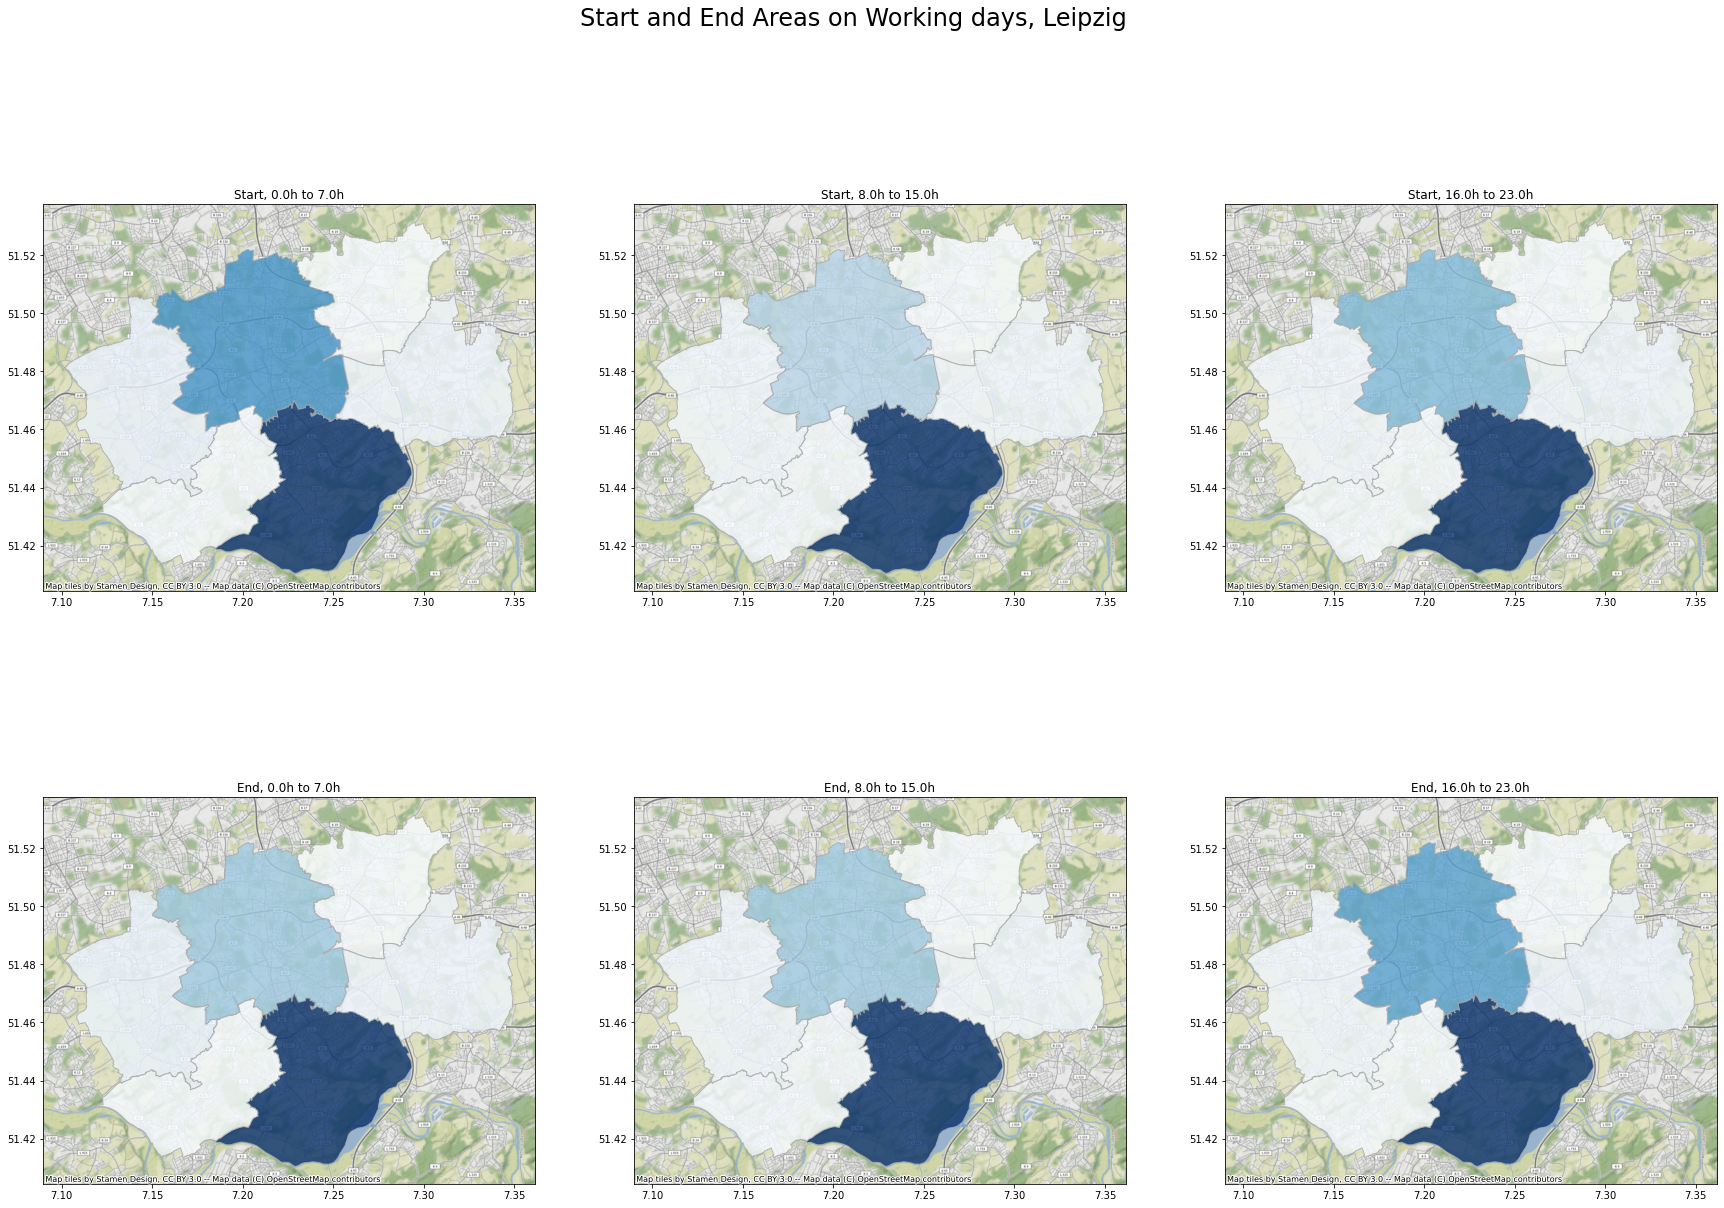

In [76]:
plot_quarter_days(df=df_b[df_b["free"]==False],polys=bochum_map,slices=3)

In [54]:
def plot_locs_split(df,polys,splits,zoom,figsize):
    slice_size = 24/splits
    fig, axes = plt.subplots(2,splits,figsize=figsize)

    polys.plot(ax=axes[0,0],zorder=1,alpha=0)

    xlim1,xlim2 = axes[0,0].get_xlim()
    ylim1,ylim2 = axes[0,0].get_ylim()
    
    xmid = xlim1+(xlim2-xlim1)/2
    ymid = ylim1+(ylim2-ylim1)/2
 
    
    #zoom feature
    xlim1 = xmid + (xlim1-xmid)/zoom
    xlim2 = xmid + (xlim2-xmid)/zoom
    ylim1 = ymid + (ylim1-ymid)/zoom
    ylim2 = ymid + (ylim2-ymid)/zoom


    i = 0
    while i < splits:

        min_time = i*slice_size
        max_time = (i+1)*slice_size - 1
        df_split = df[(df["Time"]>=min_time) & (df["Time"]<=max_time)] # filter for specific quarter of day

        u=0
        while u<2:
            polys.plot(ax=axes[u,i],zorder=1,alpha=0)
            # Plotting the KDE Plot as a heatmap


            lng = "orig_lng"
            lat = "orig_lat"
            if u ==1:
                lng = "dest_lng"
                lat = "dest_lat"

            sns.kdeplot(x=df_split[lng],
                        y=df_split[lat],
                        shade=True,
                        thresh=0.1,
                        cmap="Blues",
                        ax=axes[u,i]) 

            ctx.add_basemap(ax=axes[u,i],crs=4326,alpha=0.4)
            polys.plot(ax=axes[u,i],zorder=1,facecolor="none", edgecolor="black")

            axes[u,i].set_ylim(ylim1,ylim2)
            axes[u,i].set_xlim(xlim1,xlim2)
            
            axes[u,i].set_axis_off()
            
            u = u + 1
        
        axes[0,i].set_title(str(int(min_time))+" to "+str(int(max_time))+" O'Clock")

        i = i + 1



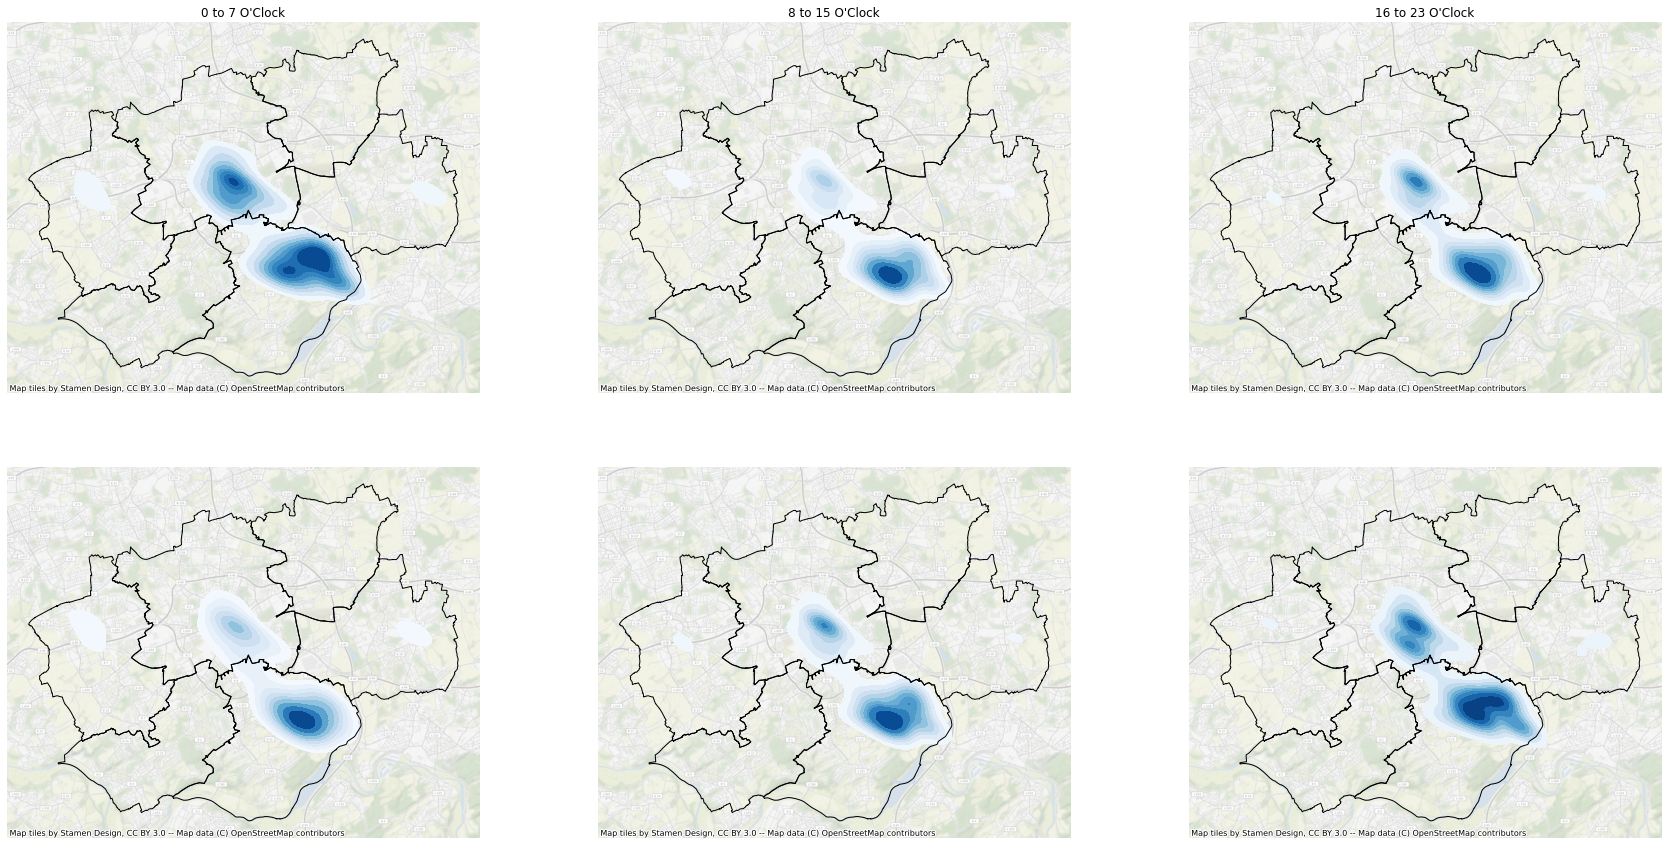

In [55]:
plot_locs_split(df=df_b[df_b["free"]==False],polys=bochum_map,splits=3,zoom=1,figsize=(30,15)) 

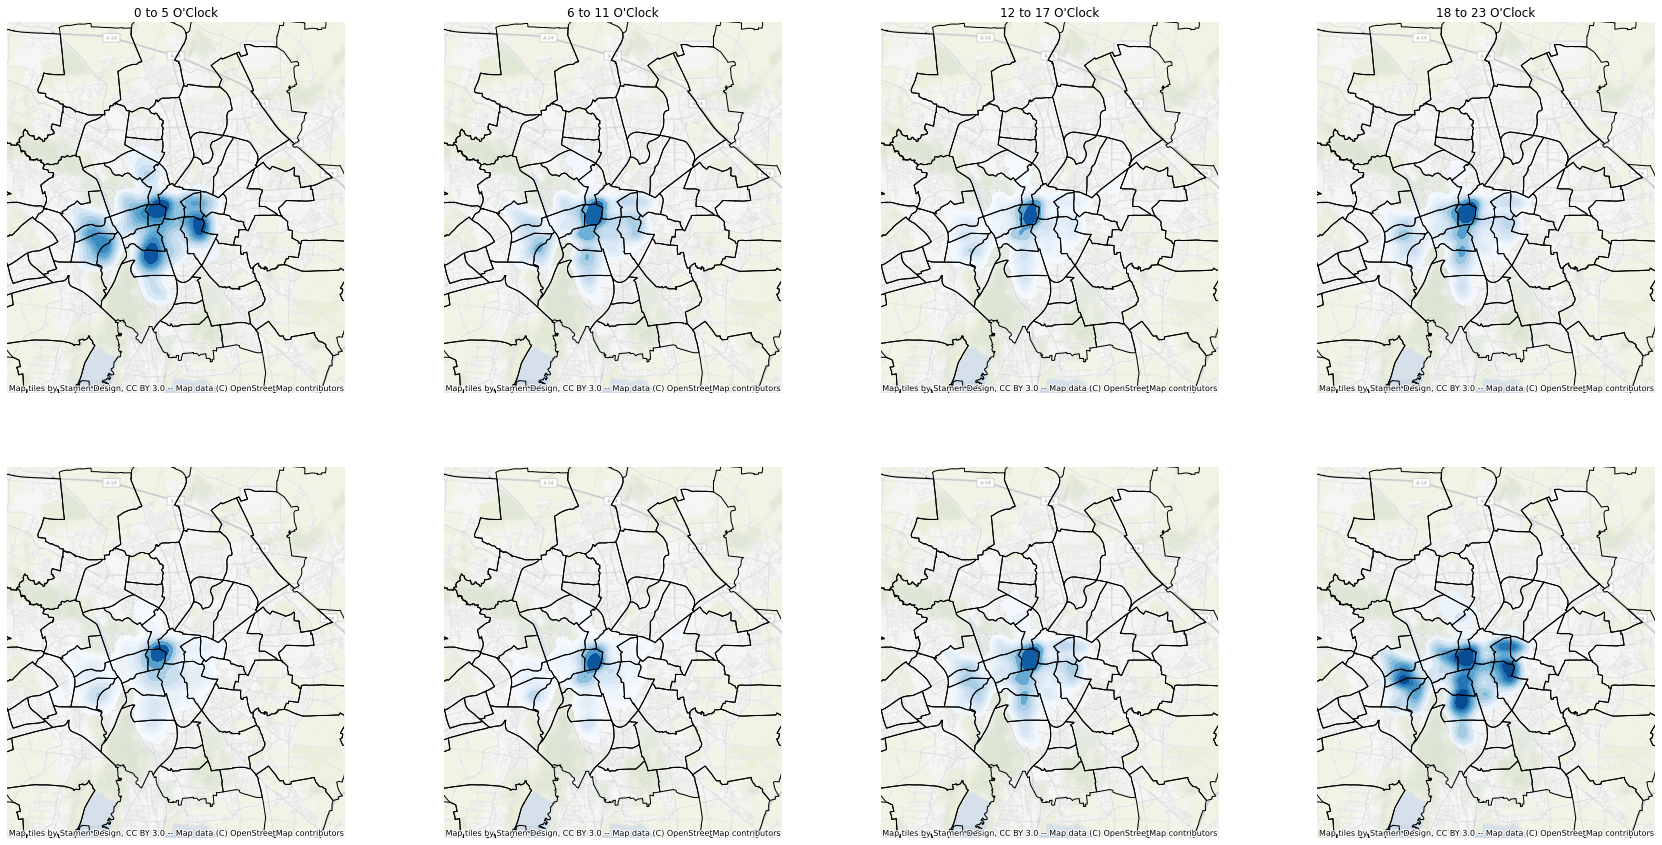

In [56]:
plot_locs_split(df=df_l[df_l["free"]==False],polys=leipzig_map,splits=4,zoom=1.5,figsize=(30,15))

____

# Clustering

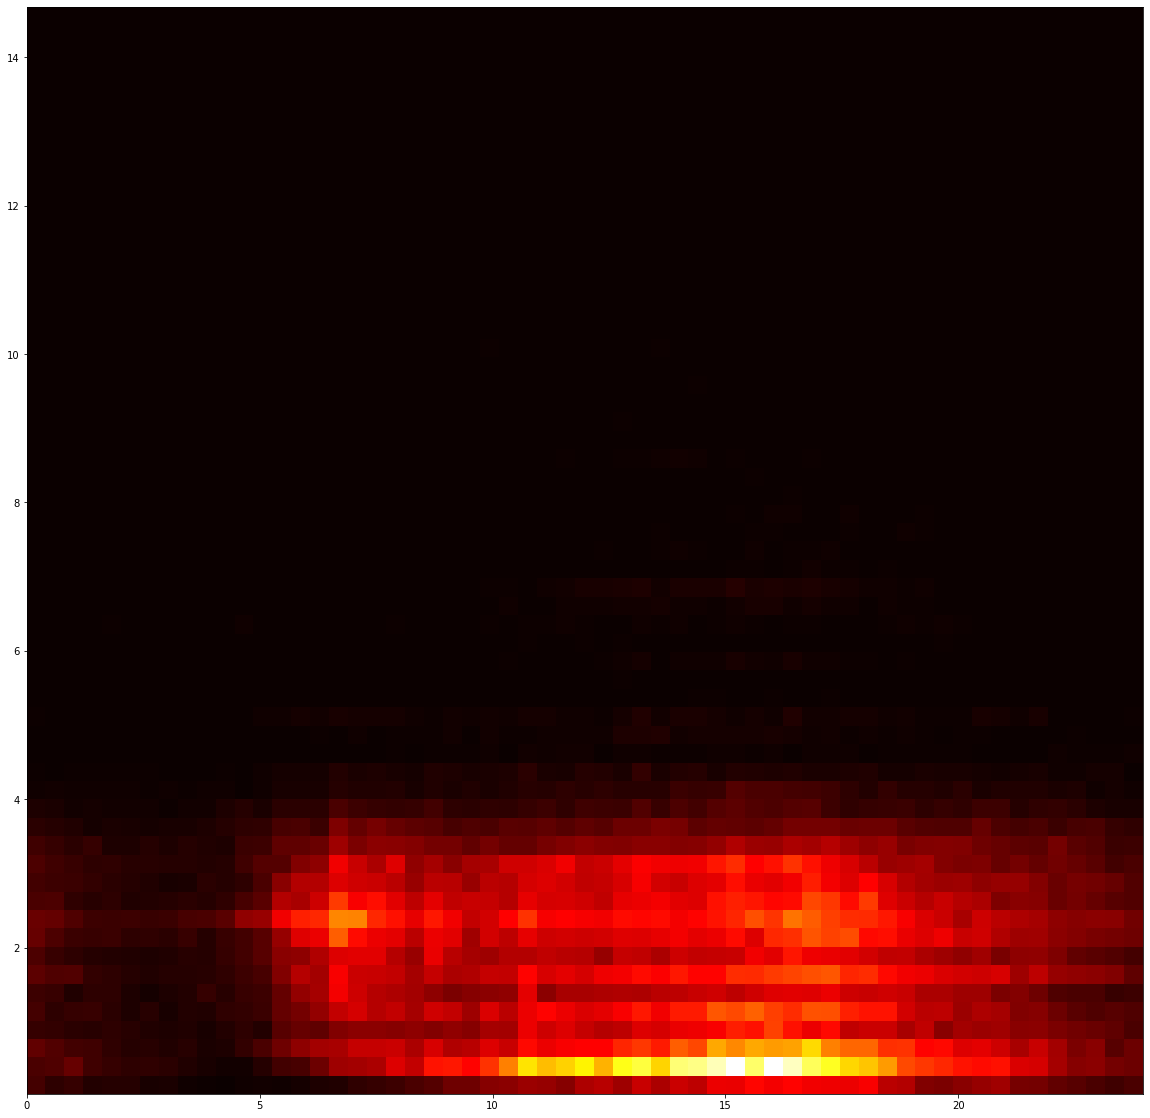

In [94]:
Fig,axis = plt.subplots(figsize=(20,20))

_ = axis.hist2d(df_l["Time_float"],
            df_l["start_distance_center"],
            bins=59,cmap="hot", 
            #range=[[0, 24], [0, 6]]
           )
#plt.scatter(df_l["Time"],df_l["start_distance_center"],alpha=0.002)

# Predictive Analytics

In [95]:
#Meteostat Data read-in
meteostat_l = pd.read_csv("./weather-data/meteostat-leipzig.csv") 
meteostat_l.index = dates
meteostat_l.drop(columns=["wpgt","wdir","date"],inplace=True)

meteostat_b = pd.read_csv("./weather-data/meteostat-bochum.csv") 
meteostat_b.index = dates
meteostat_b.drop(columns=["wpgt","wdir","date"],inplace=True)

C:\Users\Leon\anaconda3\envs\aa\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


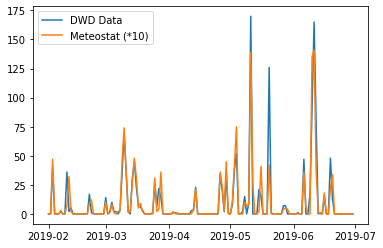

In [97]:
#Calculating the best Raster Point that is closest to the city center
testset_weather = pd.read_csv("./weather-data/dwd-raster/target/ra190201_target.csv") 

distances_center = []
for index, row in testset_weather.iterrows():
        d = {
            "LON": row["LON"],
            "LAT": row["LAT"],
            "ID": row["ID"],
            "distance": calculate_distance(row["LON"], row["LAT"], leipzig["lng"], leipzig["lat"])
        } 
        distances_center.append(d)
distances_center = pd.DataFrame(distances_center)

raster_id = distances_center.iloc[distances_center["distance"].idxmin()]["ID"]

#Read in CDC Raster Data from single files and Filter for the calculated point
import os

path = './weather-data/dwd-raster/target/'
rain_data_all = pd.concat((pd.read_csv(path+filename) for filename in os.listdir(path)))

rain_data = rain_data_all[rain_data_all["ID"] == raster_id]
rain_data.index = dates #indexing
rain_data.drop(columns=["ID"],inplace=True) 

#meteostat_leipzig.isnull().sum().sort_values(ascending=False)

plt.plot(rain_data.index,rain_data.VAL,label="DWD Data")
plt.plot(meteostat_l.index,meteostat_l.prcp*10, label="Meteostat (*10)")
plt.legend()

In [161]:
def df_predictive(df,meteostat):
    df["free_dummy"] = df["free"].astype(int)
    df = df.join(meteostat)
    df = df.drop(columns={"snow","free","daily_usage","daily_revenue","daily_used_bikes"})
    return df

df_predictive_l = df_predictive(df_date_l,meteostat_l)
df_predictive_b = df_predictive(df_date_b,meteostat_b)
df_predictive_b

daily_trips  fleet_size  free_dummy  tavg  tmin  tmax  prcp  wspd  \
date                                                                            
2019-02-01           40         103           0   1.5  -2.0   6.5   3.0    10   
2019-02-02           27         103           1   0.7  -0.4   2.2   5.7     8   
2019-02-03           27         103           1   1.4  -1.7   4.6   0.0     9   
2019-02-04           47         103           0   2.1  -1.3   4.7   0.6    15   
2019-02-05           79         103           0   2.7   0.7   4.0   0.0    11   
...                 ...         ...         ...   ...   ...   ...   ...   ...   
2019-06-26          255         213           0  25.3  18.1  30.4   0.0    12   
2019-06-27          242         220           0  19.4  14.1  25.6   0.0    12   
2019-06-28          255         228           0  18.5  11.1  25.9   0.0    10   
2019-06-29          124         223           1  23.9  11.9  33.7   0.0     7   
2019-06-30           92         220           1  24.9  17.0  31.4   0.0    13   

              pres  tsun  
date                      
2019-02-01   990.7   227  
2019-02-02   999.1     0  
2019-02-03  1019.6   174  
2019-02-04  1026.4   158  
2019-02-05  1026.9     0  
...            ...   ...  
2019-06-26  1023.1   883  
2019-06-27  1027.2   788  
2019-06-28  1025.0   770  
2019-06-29  1018.8   930  
2019-06-30  1013.8   841  

[147 rows x 10 columns]

In [162]:
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

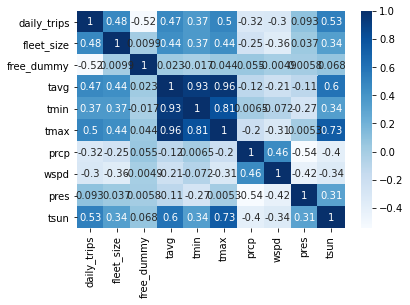

In [140]:
sns.heatmap(df_predictive_b.corr(), annot=True,cmap ="Blues")
df_predictive_b = df_predictive_b.drop(columns=["tmin","tmax"])

<AxesSubplot:>

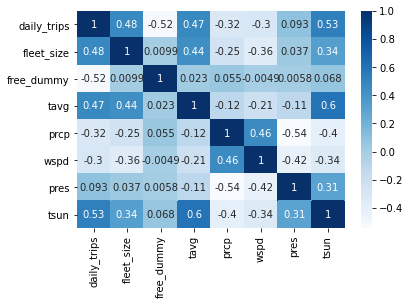

In [141]:
sns.heatmap(df_predictive_b.corr(), annot=True,cmap ="Blues")

In [163]:
X = df_predictive_b.drop(columns=["daily_trips"])
Y = df_predictive_b[["daily_trips"]]

X_n =  min_max_scaling(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_n, Y,test_size = 0.3)

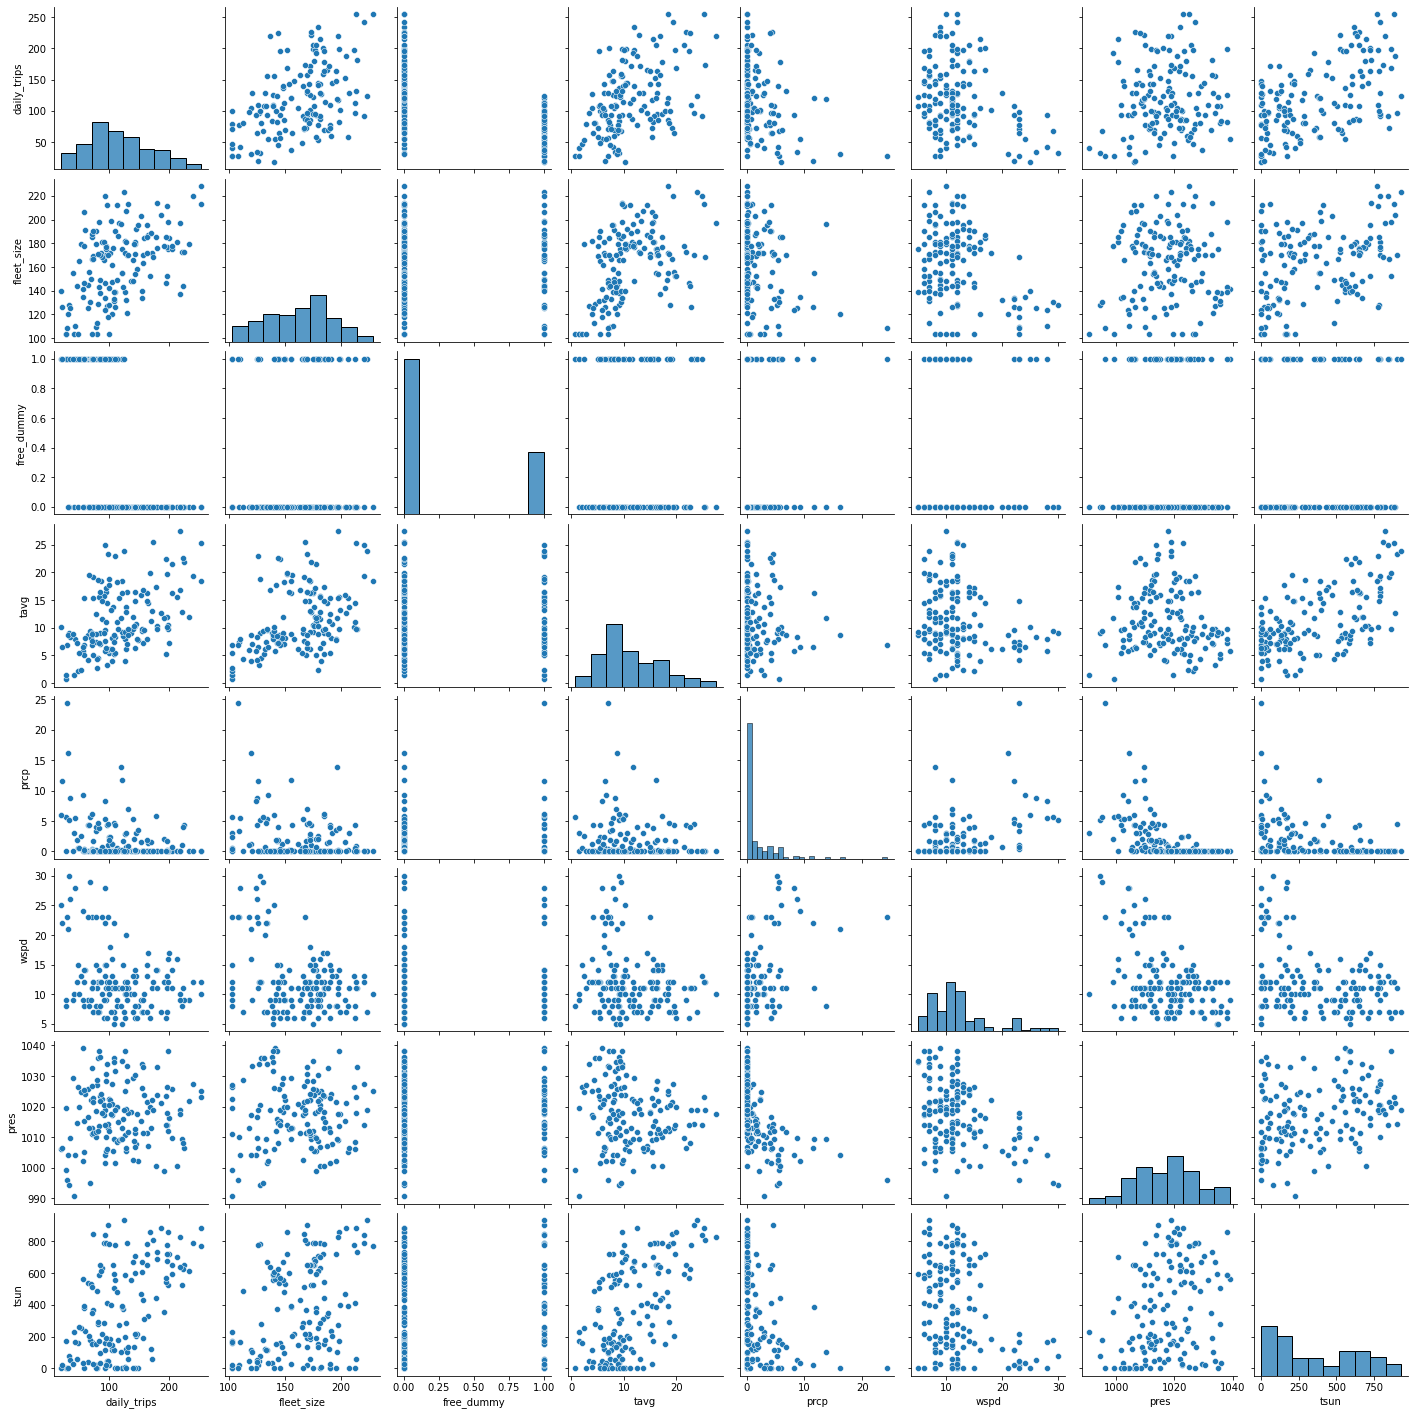

In [151]:
sns.pairplot(df_predictive_b)

TypeError: 'numpy.int64' object is not callable

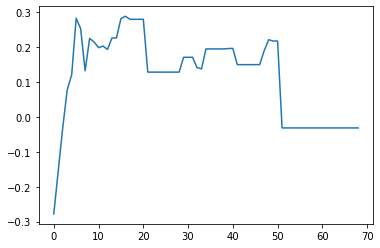

In [164]:
def tree_regression(Xtrain, Ytrain,Xtest, Ytest, min_leaves, xlabel, ylabel):
    Tree_reg = DecisionTreeRegressor(min_samples_leaf=min_leaves,criterion="mse")
    Tree_reg.fit(Xtrain, Ytrain)
    Y_pred = Tree_reg.predict(Xtest)
    
    r2= r2_score(Ytest, Y_pred)
    return r2

r2values=[]
i = 1
while i < 70:
    r2values.append(tree_regression(Xtrain = X_train, 
                                    Ytrain = Y_train,
                                    Xtest = X_test,
                                    Ytest =  Y_test, 
                                    min_leaves = i, 
                                    xlabel = "Avg Temperature", 
                                    ylabel = "Daily Trips"))
    i += 1
    
plt.plot(r2values)
r2max = np.argmax(r2values, axis=0) + 1
print("best r2 is at:", r2max,":", max(r2values))

R2: 0.12109705808681281


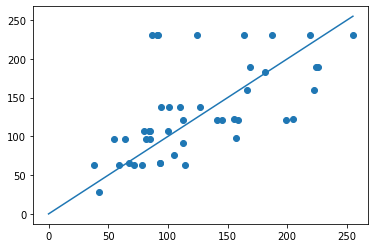

In [168]:
Tree_reg = DecisionTreeRegressor(min_samples_leaf=5,criterion="mse")
Tree_reg.fit(X_train, Y_train)
Y_pred = Tree_reg.predict(X_test)

test_set_r2 = r2_score(Y_test, Y_pred)
plt.scatter(Y_test, Y_pred)

max=Y_test.max()["daily_trips"]
x = np.linspace(0, max,max)
print("R2:", test_set_r2)
plt.plot(x,x)

R2: 0.7208570675524799


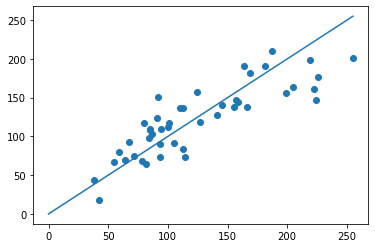

In [169]:
lin_reg_mod = LinearRegression(normalize=True)
lin_reg_mod.fit(X_train, Y_train)
pred = lin_reg_mod.predict(X_test)

test_set_r2 = r2_score(Y_test, pred)
plt.scatter(Y_test, pred)


max=Y_test.max()["daily_trips"]
x = np.linspace(0, max, max)
print("R2:", test_set_r2)
plt.plot(x,x)

In [167]:
pd.DataFrame(index=X_n.columns,data = lin_reg_mod.coef_.reshape(-1,1))


0
fleet_size   65.310891
free_dummy  -62.616586
tavg        234.784001
tmin        -60.655055
tmax       -184.447665
prcp        -28.846999
wspd        -25.347888
pres        -20.370933
tsun         84.852384

_______________________________

# Backup

In [53]:
cmap = cm.Blues

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

# Geographic Clustering for availability analysis

In [69]:
locs = df[["orig_lat","orig_lng"]].rename(columns={"orig_lat": "lat","orig_lng":"lng"})
locs.append(df[["dest_lat","dest_lng"]].rename(columns={"dest_lat": "lat","dest_lng":"lng"}),ignore_index=True)
locs["gerade"] = locs.index % 2
locs

lat     lng  gerade
0       51.330  12.342       0
1       51.330  12.342       1
2       51.330  12.342       0
3       51.330  12.342       1
4       51.343  12.376       0
...        ...     ...     ...
185319  51.325  12.338       1
185320  51.324  12.338       0
185321  51.325  12.308       1
185325  51.341  12.365       1
185326  51.325  12.337       0

[185303 rows x 3 columns]

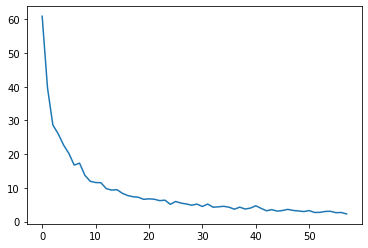

In [22]:
from sklearn.cluster import MiniBatchKMeans, KMeans

ssd = []
for i in range(2, 60):
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(locs)
    ssd.append(km.inertia_)
    
plt.plot(ssd)

In [23]:
n = 40

km = MiniBatchKMeans(n_clusters=n)
km.fit_predict(locs)
clusters = pd.DataFrame(km.cluster_centers_)
clusters.columns = ['lat', 'lng']
clusters_gdf = gpd.GeoDataFrame(
    clusters.drop(["lat","lng"],axis=1), geometry=gpd.points_from_xy(clusters["lng"], clusters["lat"]))

In [76]:
locs_gdf = gpd.GeoDataFrame(
    locs.drop(["lat","lng"],axis=1), geometry=gpd.points_from_xy(locs["lng"], locs["lat"]))
locs_gdf

gerade                   geometry
0            0  POINT (12.34200 51.33000)
1            1  POINT (12.34200 51.33000)
2            0  POINT (12.34200 51.33000)
3            1  POINT (12.34200 51.33000)
4            0  POINT (12.37600 51.34300)
...        ...                        ...
185319       1  POINT (12.33800 51.32500)
185320       0  POINT (12.33800 51.32400)
185321       1  POINT (12.30800 51.32500)
185325       1  POINT (12.36500 51.34100)
185326       0  POINT (12.33700 51.32500)

[185303 rows x 2 columns]

In [59]:
leipzig_map.head()

OT            Name                                           geometry
0  00         Zentrum  POLYGON ((12.37928 51.34436, 12.37939 51.34433...
1  01     Zentrum-Ost  POLYGON ((12.38808 51.33817, 12.38779 51.33814...
2  02  Zentrum-Südost  POLYGON ((12.39486 51.33840, 12.39445 51.33719...
3  03     Zentrum-Süd  POLYGON ((12.37855 51.33603, 12.37902 51.33603...
4  04    Zentrum-West  POLYGON ((12.36230 51.33272, 12.36226 51.33253...

________________

## Availability Analysis
This function calculates what happened between rental times. It analyzes whether, between rentals, a bike has been available at a certain station or whether it has been moved to a different location. This can then be used for example to calculate the number of available bikes at a certain station at a single time. We use it to calculate our KPI of percentage of stations without available bikes. It can be used for further analysis in this topic as well.

In [138]:
df

b_number     city   trip_duration  orig_lat  orig_lng  dest_lat  \
0          10900  leipzig 0 days 00:12:00    51.330    12.342    51.330   
1          10900  leipzig 0 days 00:08:00    51.330    12.342    51.330   
2          10900  leipzig 0 days 00:40:00    51.330    12.342    51.330   
3          10900  leipzig 0 days 00:03:00    51.330    12.342    51.330   
4          20000  leipzig 0 days 00:20:00    51.343    12.376    51.330   
...          ...      ...             ...       ...       ...       ...   
185319     82353  leipzig 0 days 00:03:00    51.325    12.338    51.324   
185320     98765  leipzig 0 days 02:55:00    51.324    12.338    51.324   
185321     99979  leipzig 0 days 00:11:00    51.325    12.308    51.325   
185325     99982  leipzig 0 days 01:44:00    51.341    12.365    51.341   
185326    999999  leipzig 0 days 00:45:00    51.325    12.337    51.325   

        dest_lng           timestamp   timestamp_rounded  weekday  week  Time  \
0         12.342 2019-04-16 11:17:00 2019-04-16 11:00:00        1    16    11   
1         12.342 2019-04-16 11:35:00 2019-04-16 11:00:00        1    16    11   
2         12.342 2019-04-16 11:53:00 2019-04-16 11:00:00        1    16    11   
3         12.342 2019-04-16 14:35:00 2019-04-16 14:00:00        1    16    14   
4         12.338 2019-05-21 09:47:00 2019-05-21 09:00:00        1    21     9   
...          ...                 ...                 ...      ...   ...   ...   
185319    12.338 2019-03-04 16:37:00 2019-03-04 16:00:00        0    10    16   
185320    12.338 2019-05-08 14:25:00 2019-05-08 14:00:00        2    19    14   
185321    12.308 2019-05-14 09:16:00 2019-05-14 09:00:00        1    20     9   
185325    12.365 2019-02-11 11:47:00 2019-02-11 11:00:00        0     7    11   
185326    12.338 2019-03-22 11:35:00 2019-03-22 11:00:00        4    12    11   

              date  revenue  max_distance_center  
0       2019-04-16      1.0                  3.0  
1       2019-04-16      1.0                  3.0  
2       2019-04-16      2.0                  3.0  
3       2019-04-16      1.0                  3.0  
4       2019-05-21      1.0                  3.0  
...            ...      ...                  ...  
185319  2019-03-04      1.0                  3.0  
185320  2019-05-08      6.0                  3.0  
185321  2019-05-14      1.0                  5.0  
185325  2019-02-11      4.0                  1.0  
185326  2019-03-22      2.0                  3.0  

[185303 rows x 15 columns]

In [107]:
df2 = df[:]

df2["timestamp_end"] = df2["timestamp"] + df2["trip_duration"]
df2=df2.drop(columns=['date', "revenue", "weekday", "Time", "timestamp_rounded","trip_duration"])

#df2 = df2.round({"orig_lat":round_factor, 'orig_lng':round_factor, 'dest_lat':round_factor, "dest_lng":round_factor})

#make sure it is sorted by b_number, then timestamp
df2 = df2.sort_values(by=['b_number','timestamp'])
#make sure the index is still +1 every time after sorting
df2.reset_index(inplace=True)
df2 = df2.rename(columns={"index": "original_index"})


df2

<ipython-input-107-8fa23d17f9fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["timestamp_end"] = df2["timestamp"] + df2["trip_duration"]


original_index  b_number     city  orig_lat  orig_lng  dest_lat  \
0                    0     10900  leipzig   51.3303   12.3420   51.3303   
1                    1     10900  leipzig   51.3303   12.3422   51.3303   
2                    2     10900  leipzig   51.3303   12.3422   51.3302   
3                    3     10900  leipzig   51.3303   12.3418   51.3303   
4                    4     20000  leipzig   51.3431   12.3765   51.3304   
...                ...       ...      ...       ...       ...       ...   
185298          185319     82353  leipzig   51.3246   12.3381   51.3245   
185299          185320     98765  leipzig   51.3244   12.3381   51.3242   
185300          185321     99979  leipzig   51.3248   12.3078   51.3250   
185301          185325     99982  leipzig   51.3412   12.3650   51.3411   
185302          185326    999999  leipzig   51.3246   12.3369   51.3246   

        dest_lng           timestamp  week  max_distance_center  \
0        12.3422 2019-04-16 11:17:00    16                  3.0   
1        12.3422 2019-04-16 11:35:00    16                  3.0   
2        12.3420 2019-04-16 11:53:00    16                  3.0   
3        12.3420 2019-04-16 14:35:00    16                  3.0   
4        12.3378 2019-05-21 09:47:00    21                  3.0   
...          ...                 ...   ...                  ...   
185298   12.3382 2019-03-04 16:37:00    10                  3.0   
185299   12.3383 2019-05-08 14:25:00    19                  3.0   
185300   12.3078 2019-05-14 09:16:00    20                  5.0   
185301   12.3650 2019-02-11 11:47:00     7                  1.0   
185302   12.3381 2019-03-22 11:35:00    12                  3.0   

             timestamp_end  
0      2019-04-16 11:29:00  
1      2019-04-16 11:43:00  
2      2019-04-16 12:33:00  
3      2019-04-16 14:38:00  
4      2019-05-21 10:07:00  
...                    ...  
185298 2019-03-04 16:40:00  
185299 2019-05-08 17:20:00  
185300 2019-05-14 09:27:00  
185301 2019-02-11 13:31:00  
185302 2019-03-22 12:20:00  

[185303 rows x 11 columns]

In [154]:
df2 = df.copy()

df2["timestamp_end"] = df2["timestamp"] + df2["trip_duration"]
df2=df2.drop(columns=['date', "revenue", "weekday", "Time", "timestamp_rounded","trip_duration","week","max_distance_center"])

df3 = []
for number in df2.b_number.unique():
    dft = df2[df2["b_number"]==number]
    dft = dft.sort_values(by="timestamp")
    i = 0
    for index, row in dft.iterrows():
        i = i + 1
        if i > 1:
            status = "moved"
            if [row["orig_lat"],row["orig_lng"]] == last_dest:
                status = "stood"
                
            d = {
                "b_number": number,
                "from": last_timestamp,
                "to": row["timestamp"],
                "status": status
            }
            df3.append(d)
        last_timestamp = row["timestamp_end"]
        last_dest = [row["dest_lat"],row["dest_lng"]]

df3 = pd.DataFrame(df3)

df3["length"] = df3["to"] - df3["from"]
df3["length_int"] = df3["length"].dt.total_seconds() / (60* 60* 24)
df3["length_int"] = df3["length_int"].round()

df3_stood = df3[df3["status"]=="stood"].sort_values(by="length_int")

stood_length = df3_stood.groupby("length_int").agg(
    count = ("b_number","count")
)

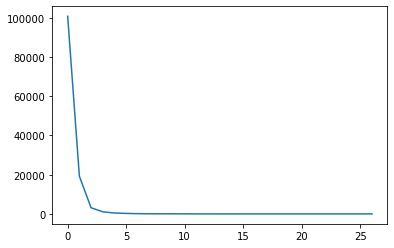

In [157]:
plt.plot(stood_length)

This step will take a while, as it clusters each entry to a specific cluster point, which takes a lot of computing power.

In [36]:
df3 = []

bike_number = 0
bike_city = ""

for index in df2.index:
    if  df2.at[index,"b_number"] != bike_number:
        bike_number = df2.at[index,"b_number"]
        bike_city = df2.at[index,"city"]
    else:
        lat = df2.at[index,"orig_lat"]
        lng = df2.at[index,"orig_lng"]
        cluster_point = next_cluster(lng,lat,clusters)
        time_start = df2.at[index-1,"timestamp_end"]
        time_end = df2.at[index,"timestamp"]
        
        #status
        if index % 20000 == 0:
            print("reached row", index, "of", df2.index.max())
        
        action_type = "station"
        if lat == df2.at[index-1,"dest_lat"] and lng != df2.at[index-1,"dest_lng"]:
            action_type = "moved"
            
        d = {
            'b_number' : bike_number,
            'b_city' : bike_city,
            'lat' : lat,  # some formula for obtaining values
            'lng' : lng,
            'timestamp' : time_start,
            'action_type' : action_type+"_in",
            'cluster_point': cluster_point
            }
        df3.append(d)
        d = {
            'b_number' : bike_number,
            'b_city' : bike_city,
            'lat' : lat,  # some formula for obtaining values
            'lng' : lng,
            'timestamp' : time_end,
            'action_type' : action_type+"_out",
            'cluster_point': cluster_point
            }
        df3.append(d)

df3 = pd.DataFrame(df3)

reached row 20000 of 185302
reached row 40000 of 185302
reached row 60000 of 185302
reached row 80000 of 185302
reached row 100000 of 185302
reached row 120000 of 185302
reached row 140000 of 185302
reached row 160000 of 185302
reached row 180000 of 185302


In [37]:
df3["cluster_point"] = df3["cluster_point"].astype(str)
df3

b_number   b_city        lat        lng           timestamp  \
0          10900  leipzig  51.330347  12.342159 2019-04-16 11:29:00   
1          10900  leipzig  51.330347  12.342159 2019-04-16 11:35:00   
2          10900  leipzig  51.330267  12.342196 2019-04-16 11:43:00   
3          10900  leipzig  51.330267  12.342196 2019-04-16 11:53:00   
4          10900  leipzig  51.330298  12.341811 2019-04-16 12:33:00   
...          ...      ...        ...        ...                 ...   
368585     82351  leipzig  51.324833  12.308134 2019-03-07 13:40:00   
368586     82353  leipzig  51.324656  12.337997 2019-02-27 08:40:00   
368587     82353  leipzig  51.324656  12.337997 2019-02-28 10:57:00   
368588     82353  leipzig  51.324591  12.338144 2019-02-28 11:00:00   
368589     82353  leipzig  51.324591  12.338144 2019-03-04 16:37:00   

        action_type                           cluster_point  
0        station_in  [12.34531110098789, 51.32944343266105]  
1       station_out  [12.34531110098789, 51.32944343266105]  
2        station_in  [12.34531110098789, 51.32944343266105]  
3       station_out  [12.34531110098789, 51.32944343266105]  
4        station_in  [12.34531110098789, 51.32944343266105]  
...             ...                                     ...  
368585  station_out  [12.3152057316387, 51.326728945383735]  
368586   station_in  [12.337831945018122, 51.3267264356117]  
368587  station_out  [12.337831945018122, 51.3267264356117]  
368588   station_in  [12.337831945018122, 51.3267264356117]  
368589  station_out  [12.337831945018122, 51.3267264356117]  

[368590 rows x 7 columns]

This algorithm takes goes over all records that relate to bikes standing at a certain station. For each change event, it calculates the effect on the capacity of a certain station.

In [38]:
#filter df3 for all events related to bikes standing at a station (not being moved between rides)
df3 = df3[df3["action_type"].isin(["station_in","station_out"])]

#filter correctly for the algorithm to work properly
df3=df3.sort_values(by=['cluster_point','timestamp','action_type'])
df3.reset_index(inplace=True)
df3 = df3.rename(columns={"index": "original_index"})

df3["count"] = 0

station = ""
count = 0

for index in df3.index:
    action_type = df3.at[index,"action_type"]
    #if this is a different station, restart the calculation
    if  df3.at[index,"cluster_point"] != station:
        station = df3.at[index,"cluster_point"]
        count = 0
    if action_type == "station_in":
         count = count + 1
    elif action_type == "station_out":
        count = count - 1
    else:
        print("there was an error")
    
    df3.at[index,"count"] = count

In [39]:
df3

original_index  b_number   b_city        lat        lng  \
0               138476     23140  leipzig  51.350020  12.291401   
1                51364     20332  leipzig  51.347631  12.313274   
2               156882     23188  leipzig  51.350020  12.291401   
3               156883     23188  leipzig  51.350020  12.291401   
4               303728     23569  leipzig  51.353337  12.303199   
...                ...       ...      ...        ...        ...   
355489           66029     20370  leipzig  51.344938  12.422246   
355490           19371     20247  leipzig  51.342796  12.427372   
355491          208691     23314  leipzig  51.342911  12.427218   
355492          291757     23539  leipzig  51.343262  12.427448   
355493          318565     23606  leipzig  51.342929  12.427463   

                 timestamp  action_type  \
0      2019-02-01 07:24:00   station_in   
1      2019-02-01 09:03:00   station_in   
2      2019-02-01 10:19:00   station_in   
3      2019-02-01 13:06:00  station_out   
4      2019-02-01 16:21:00   station_in   
...                    ...          ...   
355489 2019-06-30 16:16:00  station_out   
355490 2019-06-30 17:25:00  station_out   
355491 2019-06-30 17:25:00  station_out   
355492 2019-06-30 17:25:00  station_out   
355493 2019-06-30 17:25:00  station_out   

                                   cluster_point  count  
0        [12.308374186714172, 51.35111801349967]      1  
1        [12.308374186714172, 51.35111801349967]      2  
2        [12.308374186714172, 51.35111801349967]      3  
3        [12.308374186714172, 51.35111801349967]      2  
4        [12.308374186714172, 51.35111801349967]      3  
...                                          ...    ...  
355489  [12.424011260192936, 51.349616561503616]      4  
355490  [12.424011260192936, 51.349616561503616]      3  
355491  [12.424011260192936, 51.349616561503616]      2  
355492  [12.424011260192936, 51.349616561503616]      1  
355493  [12.424011260192936, 51.349616561503616]      0  

[355494 rows x 9 columns]

This part produces a list of the minimum available bikes at a certain station. For example, if a station has had 2 bikes for the first ten minutes, then had 3 and in the end had only 1 bike left, this would count as 1 bike for the respective hour period. 
* If there was no change in available bikes, it takes the value for the most recent change event.
* If the number of available bikes changes to zero and no bikes ever get to the station again until the end of the data timeframe, it will not count as 0 bikes as the station might have been closed in the meantime (this should not count as "no bikes available)

In [40]:
df3["timestamp_rounded"] = df3["timestamp"].dt.floor("H")
df3 = df3.sort_values(by=['cluster_point','timestamp'])

start_date = df3.timestamp_rounded.min()
end_date = df3.timestamp_rounded.max()
daterange = pd.date_range(start_date, end_date,freq='1H')

df4 = pd.DataFrame(index=daterange)

for cluster_point in df3.cluster_point.unique():
    dfl = df3[df3.cluster_point == cluster_point]
    dfl = dfl.groupby("timestamp_rounded").agg(
    min_count =("count","min"),
    last_value = ("count", lambda x: x.iloc[-1]))
    dfl = dfl.reindex(daterange, fill_value=None)
    dfl["last_value"] = dfl["last_value"].fillna(method='ffill')
    dfl["min_count"] = dfl.apply(
        lambda row: row['last_value']if np.isnan(row['min_count']) else row['min_count'],axis=1
    )
    for index, row in dfl[::-1].iterrows():
        if row["min_count"] == 0:
            row["min_count"] = None
        else:
            break
    df4[cluster_point] = dfl["min_count"]
    
df4 = df4.T

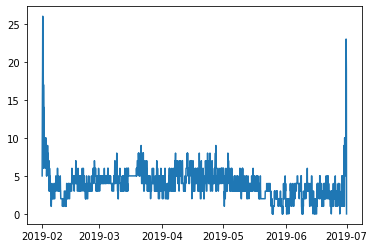

In [41]:
#df4.to_excel("transposed.xlsx")
df5 = df4[df4 < 4].count()
df5
plt.plot(df5)

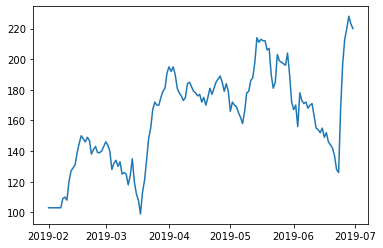

In [117]:
plt.plot(fleet_size_b)

_______________________________

## Visualisation

In [43]:
dates = df_by_date_merged.index
fleetsize = df_by_date_merged["fleet_size"]
usage = df_by_date_merged["usage"]
usedbikes = df_by_date_merged["used_bikes"]

Fig_1, ax_1 = plt.subplots()


color = 'tab:red'
ax_1.set_xlabel('Date')
ax_1.set_ylabel('Fleet Size', color=color)
ax_1.plot(dates, fleetsize, color=color)
ax_1.tick_params(axis='y', labelcolor=color)

ax_2 = ax_1.twinx()  # instantiate a second axes that shares the same x-axis


color = 'tab:blue'

ax_2.set_ylabel("Used Bikes", color=color)
ax_2.plot(dates, usedbikes, color=color)
ax_2.tick_params(axis='y', labelcolor=color)

Fig_1.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

KeyError: 'used_bikes'

## Group by rounded start time

In [ ]:
df_by_time = df.groupby("Time").agg(
    mean_length=('trip_duration', lambda x: np.mean(x)),
    trip_count=('b_number', 'count'))

In [ ]:
fig, (ax1, ax1_b) = plt.subplots(nrows = 1, ncols = 2, figsize= (12,4))

x = df_by_time.index
seconds = df_by_time["mean_length"].dt.total_seconds()/60
amount = df_by_time["trip_count"]

color = 'tab:red'
ax1.set_xlabel('Time of the day')
ax1.set_ylabel('Average trip length', color=color)
ax1.plot(x, seconds, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Total amount of trips', color=color)  # we already handled the x-label with ax1
ax2.plot(x, amount, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

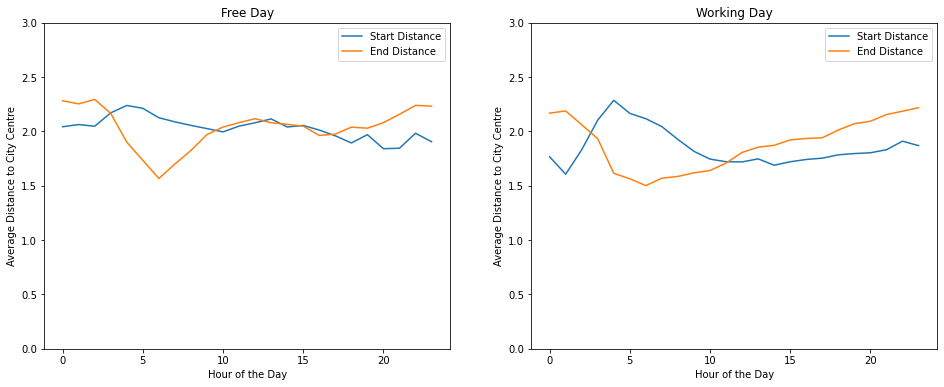

In [16]:
df_distance_pattern = df.merge(date_info,left_on="date",right_index=True)
df_distance_pattern["holiday"] = df_distance_pattern["holiday"].astype(bool)
df_distance_pattern["free"] = df_distance_pattern["day_classifier"] == "weekend"
df_distance_pattern["free"] = df_distance_pattern["free"] | df_distance_pattern["holiday"]

df_distance_pattern_f = df_distance_pattern[df_distance_pattern["free"]==True]
df_distance_pattern_f = df_distance_pattern_f.groupby(["Time"]).agg(
                            start_distance_center = ("start_distance_center","mean"),
                            end_distance_center = ("end_distance_center","mean"))

df_distance_pattern_wd = df_distance_pattern[df_distance_pattern["free"]==False]
df_distance_pattern_wd = df_distance_pattern_wd.groupby(["Time"]).agg(
                            start_distance_center = ("start_distance_center","mean"),
                            end_distance_center = ("end_distance_center","mean"))


Fig_1, axes = plt.subplots(1, 2, figsize=(16, 6))

x = df_distance_pattern_f.index
y1 = df_distance_pattern_f["start_distance_center"]
y2 = df_distance_pattern_f["end_distance_center"]
axes[0].plot(x,y1,label="Start Distance")
axes[0].plot(x,y2,label="End Distance")
axes[0].set_title('Free Day')

x = df_distance_pattern_wd.index
y1 = df_distance_pattern_wd["start_distance_center"]
y2 = df_distance_pattern_wd["end_distance_center"]
axes[1].plot(x,y1,label="Start Distance")
axes[1].plot(x,y2,label="End Distance")
axes[1].set_title('Working Day')

for axis in axes:
    axis.set_ylim([0,3])
    axis.set_xlabel('Hour of the Day')
    axis.set_ylabel('Average Distance to City Centre')
    axis.legend()

    